# QTAIM Critical Points

This example illustrates how to find the QTAIM critical points using ChemTools and ChemToolsCUDA. This is precisely
when the gradient of the electron density $\nabla \rho = 0$ is zero. The first step is to load the wavefunction information using ChemToolsCUDA.

In [1]:
import chemtools_cuda
import numpy as np

# Load the wavefunction information
fchk_path = "./ALA_ALA_0_q000_m01_k00_force_uwb97xd_def2svpd.fchk"
mol = chemtools_cuda.Molecule(fchk_path)

# Get the atomic coordinates and numbers
atom_coords = mol.coordinates
atom_numbers = mol.numbers
natoms = atom_coords.shape[0]

The next step is to construct initial points where the gradient is thought to be zero. This occurs near the center of the atoms, inbetween two atoms, and further inbetween three/four atoms. The following procedure should work for all types of molecules and is vectorized in order to increase computational time. However, it may run out of memory. This is circumvented by efficiently searching for the ten closet neighbors of each atom and finding the midpoints between them.

In [2]:
from scipy.spatial import KDTree

# Start by adding the coordinates of the atom
init_pts = mol.coordinates.copy()

# Add the midpoint between any two atoms
arr1 = init_pts.copy()[:, np.newaxis, :]
init_pts = np.vstack((init_pts, np.reshape((arr1 + init_pts) / 2.0, (len(init_pts) * len(init_pts), 3))))

# Construct a KDTree, and search for (usually) ten neighbours at a time.
tree = KDTree(atom_coords)
nbhrs = min(natoms, 10)

# Go through each atom
for i in range(natoms):
    # Grab `nbhrs` closest atoms of the current atom. 
    _, indices = tree.query(atom_coords[i], k=nbhrs)
    
    # Using only the `nbhrs` atoms, construct midpoints every three atoms.
    coords = atom_coords[indices]
    arr1 = coords.copy()[:, np.newaxis, np.newaxis, :]
    arr2 = coords.copy()[np.newaxis, :, np.newaxis, :]
    init_pts = np.vstack((init_pts, np.reshape((arr1 + arr2 + coords) / 3.0, (nbhrs ** 3, 3))))

    # Using only the `nbhrs` atoms, construct midpoints every four atoms.
    arr1 = coords.copy()[:, np.newaxis, np.newaxis, np.newaxis, :]
    arr2 = coords.copy()[np.newaxis, :, np.newaxis, np.newaxis, :]
    arr3 = coords.copy()[np.newaxis, np.newaxis, :, np.newaxis, :]
    init_pts = np.vstack((init_pts, np.reshape((arr1 + arr2 + arr3 + coords) / 4.0, (nbhrs ** 4, 3))))
    
# Remove any duplicates
init_pts = np.unique(np.round(init_pts, decimals=10), axis=0)

Obtain the electron density, gradient and hessian and use it to run the ChemTools algorithm for efficiently finding the critical points and then find the bond-paths for all bond-critical points.

In [3]:
from chemtools.topology.critical import Topology

dens_func = mol.compute_density
grad_func = mol.compute_gradient
hess_func = mol.compute_hessian

topo = Topology(dens_func, grad_func, hess_func, init_pts)
topo.find_critical_points_vectorized(atom_coords, use_log=True, verbose=True)
topo.find_bond_paths(tol=1e-8, max_ss=0.1)

Start Critical Points Finding.
Number of initial points: 7078
Iteration: 1,   Sum Gradient Norm of pts left: 13795.26664591485   Number of pts left: 7078
Iteration: 2,   Sum Gradient Norm of pts left: 16780.400882584137   Number of pts left: 6406
Iteration: 3,   Sum Gradient Norm of pts left: 8817.066657700365   Number of pts left: 5621
Iteration: 4,   Sum Gradient Norm of pts left: 6677.456524919042   Number of pts left: 5044
Iteration: 5,   Sum Gradient Norm of pts left: 7703.419316732867   Number of pts left: 4542
Iteration: 6,   Sum Gradient Norm of pts left: 5181.546111085325   Number of pts left: 3644
Iteration: 7,   Sum Gradient Norm of pts left: 3920.4795305932676   Number of pts left: 2636
Iteration: 8,   Sum Gradient Norm of pts left: 2872.2573213748974   Number of pts left: 1780
Iteration: 9,   Sum Gradient Norm of pts left: 1989.0294892860857   Number of pts left: 1171
Iteration: 10,   Sum Gradient Norm of pts left: 1207.2857892143145   Number of pts left: 750
Iteration: 11

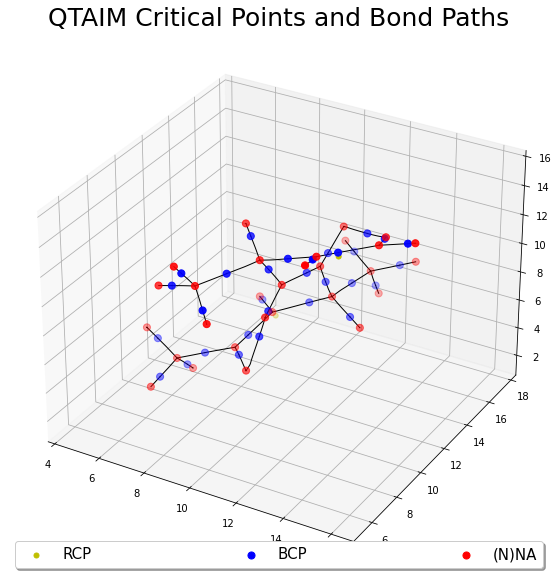

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# Grab the critical points
bcp = np.array([x.coordinate for x in topo.bcp])
nna = np.array([x.coordinate for x in topo.nna])
rcp = np.array([x.coordinate for x in topo.rcp])
ccp = np.array([x.coordinate for x in topo.ccp])
    
# Plot the critical points and bond paths
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})
# Plot the bond paths
for i in range(0, len(topo.bcp)):
    for j in range(0, 2):
        p = topo.bp[i][j]
        ax.plot(p[:, 0], p[:, 1], p[:, 2], c="k", linewidth=1)
# Plot the critical points
if len(rcp) != 0:
    ax.scatter(rcp[:, 0], rcp[:, 1], rcp[:, 2], c="y", label="RCP", s=25)
if len(ccp) != 0:
    ax.scatter(ccp[:, 0], ccp[:, 1], ccp[:, 2], c="m", label="CCP", s=25)
ax.scatter(bcp[:, 0], bcp[:, 1], bcp[:, 2], c="b", label="BCP", s=50)
ax.scatter(nna[:, 0], nna[:, 1], nna[:, 2], c="r", label="(N)NA", s=50)
plt.legend(loc="lower center", shadow=True, fontsize=15, ncol=4, mode="expand") #
plt.title("QTAIM Critical Points and Bond Paths", fontsize=25)
plt.show()